## Problem statement:

ToMe expects a single tensor to be passed to calls to `.attn`

Then inside the attn block, q,k,v are created

Therefore it can merge tokens before entering the attn block and unmerge them coming out and (input, output) will have the same shape.

My problem is that I  am passing in q,k,v to the transformer block, because they tracking some history of q,k,v states

How can I:
- merge(q), merge(k), merge(v)
- out = attn(q, k, v)
- unmerge out without loss of information
??





In [95]:
import torch
from torchvision import transforms
import torch.nn.functional as F
import time

from tome import bipartite_soft_matching, apply_merge

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
### CONSTANTS
lr = 0.001
weight_decay = 0.05
num_iterations = 2000
# number of tokens to merge
r = 1
# set dty;e
dtype = torch.float32

In [132]:
# manually seeded values all have same value
torch.manual_seed(0)
q = torch.rand(1, 4, 5).to(dtype)
k = q
# change seed for k to get some different value
torch.manual_seed(1)
v = torch.rand(1, 4, 5).to(dtype)
q, v

(tensor([[[0.4963, 0.7682, 0.0885, 0.1320, 0.3074],
          [0.6341, 0.4901, 0.8964, 0.4556, 0.6323],
          [0.3489, 0.4017, 0.0223, 0.1689, 0.2939],
          [0.5185, 0.6977, 0.8000, 0.1610, 0.2823]]]),
 tensor([[[0.7576, 0.2793, 0.4031, 0.7347, 0.0293],
          [0.7999, 0.3971, 0.7544, 0.5695, 0.4388],
          [0.6387, 0.5247, 0.6826, 0.3051, 0.4635],
          [0.4550, 0.5725, 0.4980, 0.9371, 0.6556]]]))

## Combining q,k,v first

In [55]:
qkv = q + k + v
qkv

tensor([[[1.4888, 2.3047, 0.2654, 0.3961, 0.9223],
         [1.9022, 1.4703, 2.6893, 1.3669, 1.8969],
         [1.0467, 1.2052, 0.0670, 0.5066, 0.8817],
         [1.5556, 2.0930, 2.4000, 0.4831, 0.8468]]])

In [45]:
mqkv, uqkv = bipartite_soft_matching(qkv, r)

In [63]:
merged_qkv = apply_merge(qkv, mqkv)
merged_qkv

tensor([[[1.0467, 1.2052, 0.0670, 0.5066, 0.8817],
         [1.9022, 1.4703, 2.6893, 1.3669, 1.8969],
         [1.5222, 2.1988, 1.3327, 0.4396, 0.8845]]])

In [67]:
# chunk back into q, k, v
chunk_q, chunk_k, chunk_v = torch.chunk(merged_qkv, 3, dim=1)
chunk_q

tensor([[[1.0467, 1.2052, 0.0670, 0.5066, 0.8817]]])

In [71]:
# produces attention of incorrect shape
merged_chunk_attn = F.scaled_dot_product_attention(chunk_q, chunk_k, chunk_v)
merged_chunk_attn

tensor([[[1.5222, 2.1988, 1.3327, 0.4396, 0.8845]]])

In [99]:
# get merge, unmerge functions for each token
mq, uq = bipartite_soft_matching(q, r)
mk, uk = bipartite_soft_matching(k, r)
mv, uv = bipartite_soft_matching(v, r)

In [100]:
# merge will also result in the same value 
merged_q = apply_merge(q, mq)
merged_k = apply_merge(k, mk)
merged_v = apply_merge(v, mv)
merged_q, merged_v

(tensor([[[0.3489, 0.4017, 0.0223, 0.1689, 0.2939],
          [0.6341, 0.4901, 0.8964, 0.4556, 0.6323],
          [0.5074, 0.7329, 0.4442, 0.1465, 0.2948]]]),
 tensor([[[0.7576, 0.2793, 0.4031, 0.7347, 0.0293],
          [0.7193, 0.4609, 0.7185, 0.4373, 0.4512],
          [0.4550, 0.5725, 0.4980, 0.9371, 0.6556]]]))

In [101]:
# unmerging
unmerged_q = uq(merged_q)
unmerged_v = uv(merged_v)
unmerged_q, unmerged_v

(tensor([[[0.5074, 0.7329, 0.4442, 0.1465, 0.2948],
          [0.6341, 0.4901, 0.8964, 0.4556, 0.6323],
          [0.3489, 0.4017, 0.0223, 0.1689, 0.2939],
          [0.5074, 0.7329, 0.4442, 0.1465, 0.2948]]]),
 tensor([[[0.7576, 0.2793, 0.4031, 0.7347, 0.0293],
          [0.7193, 0.4609, 0.7185, 0.4373, 0.4512],
          [0.7193, 0.4609, 0.7185, 0.4373, 0.4512],
          [0.4550, 0.5725, 0.4980, 0.9371, 0.6556]]]))

In [102]:
# scaled dot product attention
attn = F.scaled_dot_product_attention(q, k, v)
attn

tensor([[[0.6644, 0.4402, 0.5820, 0.6493, 0.3951],
         [0.6665, 0.4440, 0.5968, 0.6577, 0.4172],
         [0.6651, 0.4410, 0.5845, 0.6426, 0.3957],
         [0.6619, 0.4446, 0.5891, 0.6611, 0.4132]]])

In [103]:
merged_attn = F.scaled_dot_product_attention(merged_q, merged_k, merged_v)
merged_attn

tensor([[[0.6420, 0.4424, 0.5467, 0.6977, 0.3897],
         [0.6442, 0.4528, 0.5723, 0.6683, 0.4149],
         [0.6389, 0.4495, 0.5561, 0.6908, 0.4058]]])

In [107]:
# Observation: we get different unmerged values using uq and uv which had different matching schemes
# mismatches are only in the first dimension
unmerged_attn = uq(merged_attn)
unmerged_attn_2 = uv(merged_attn)
unmerged_attn, unmerged_attn_2

(tensor([[[0.6389, 0.4495, 0.5561, 0.6908, 0.4058],
          [0.6442, 0.4528, 0.5723, 0.6683, 0.4149],
          [0.6420, 0.4424, 0.5467, 0.6977, 0.3897],
          [0.6389, 0.4495, 0.5561, 0.6908, 0.4058]]]),
 tensor([[[0.6420, 0.4424, 0.5467, 0.6977, 0.3897],
          [0.6442, 0.4528, 0.5723, 0.6683, 0.4149],
          [0.6442, 0.4528, 0.5723, 0.6683, 0.4149],
          [0.6389, 0.4495, 0.5561, 0.6908, 0.4058]]]))

## Apply ToMe to Cifar10

In [3]:
## patch embed + pos enc
import numpy as np
import matplotlib.pyplot as plt
from torchvision.io import read_image
from mae import PatchEmbed, Mlp
from util.pos_embed import get_2d_sincos_pos_embed

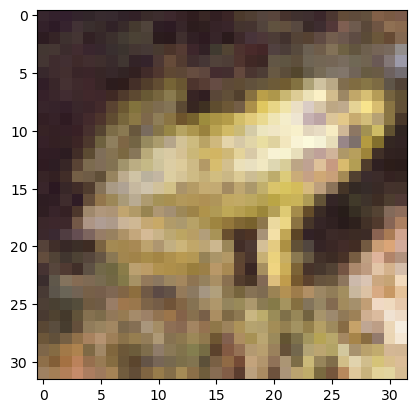

In [86]:
img = read_image('assets/frog.jpg')
plt.imshow(img.permute(1,2,0).numpy())

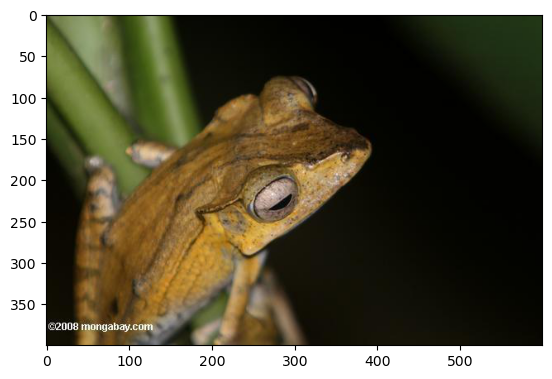

In [87]:
img2 = read_image('assets/tree_frog.jpg')
plt.imshow(img2.permute(1,2,0).numpy())

In [119]:
img = img.to(dtype)
img = F.normalize(img)

In [33]:
# unsqueeze
batched_img = img.unsqueeze(0).to(dtype)
batched_img

tensor([[[[0.1291, 0.1185, 0.1050,  ..., 0.1418, 0.1353, 0.1330],
          [0.1197, 0.1046, 0.1133,  ..., 0.1211, 0.1586, 0.1492],
          [0.1057, 0.1231, 0.1301,  ..., 0.1167, 0.1131, 0.1416],
          ...,
          [0.2958, 0.3090, 0.3400,  ..., 0.2105, 0.2351, 0.2270],
          [0.3334, 0.3020, 0.3442,  ..., 0.2324, 0.2396, 0.2367],
          [0.3710, 0.3787, 0.3757,  ..., 0.2465, 0.2506, 0.2324]],

         [[0.1178, 0.0997, 0.0863,  ..., 0.1230, 0.1172, 0.1119],
          [0.1023, 0.0816, 0.0974,  ..., 0.1089, 0.1458, 0.1318],
          [0.0868, 0.1088, 0.1364,  ..., 0.1115, 0.0963, 0.1293],
          ...,
          [0.3163, 0.3233, 0.3368,  ..., 0.2191, 0.2383, 0.2263],
          [0.3442, 0.2841, 0.3145,  ..., 0.2499, 0.2474, 0.2350],
          [0.4000, 0.3838, 0.3535,  ..., 0.2704, 0.2773, 0.2350]],

         [[0.1641, 0.1560, 0.1499,  ..., 0.1227, 0.1090, 0.1051],
          [0.1499, 0.1347, 0.1532,  ..., 0.1142, 0.1350, 0.1122],
          [0.1177, 0.1347, 0.1566,  ..., 0

In [200]:
# the following calls as a function
def prep_image(path):
    img = read_image(path)
    img = img.to(dtype)
    img = F.normalize(img)
    img = img.unsqueeze(0)
    return img

In [100]:
embed_dim = 128
patch_size = 4
in_chans = 3
img_size = 32
patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
num_patches = patch_embed.num_patches
num_patches

64

In [105]:
x = patch_embed(batched_img)
x.shape

torch.Size([1, 64, 128])

In [101]:
pos_embed = torch.nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)
pos_embed.shape

torch.Size([1, 65, 128])

In [102]:
grid_size = int(patch_embed.num_patches**.5)
print(grid_size)
print(pos_embed.shape[-1])
pos_embed_data = get_2d_sincos_pos_embed(pos_embed.shape[-1], grid_size, cls_token=True)
pos_embed_data.shape, pos_embed_data

8
128


((65, 128),
 array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 0.84147102,  0.68156135,  0.53316844, ...,  1.        ,
          1.        ,  1.        ],
        ...,
        [-0.95892429, -0.57112712,  0.32393527, ...,  0.99999863,
          0.99999923,  0.99999958],
        [-0.27941549, -0.97739613, -0.23036753, ...,  0.99999863,
          0.99999923,  0.99999958],
        [ 0.65698659, -0.85931349, -0.71372128, ...,  0.99999863,
          0.99999923,  0.99999958]]))

In [103]:
# copy data in parameter
pos_embed.data.copy_(torch.from_numpy(pos_embed_data).float().unsqueeze(0))

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.8415,  0.6816,  0.5332,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [-0.9589, -0.5711,  0.3239,  ...,  1.0000,  1.0000,  1.0000],
         [-0.2794, -0.9774, -0.2304,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.6570, -0.8593, -0.7137,  ...,  1.0000,  1.0000,  1.0000]]])

In [106]:
x += pos_embed[:, 1:, :]

## Separating Out Attention

Get Q,K,V separately

Then apply scaled dot product attention

In [344]:
# fully connected layers to get q, k, v from embed
to_q = torch.nn.Linear(embed_dim, embed_dim)
to_k = torch.nn.Linear(embed_dim, embed_dim)
to_v = torch.nn.Linear(embed_dim, embed_dim)

# sourced from fully connected layer
fcq, fck, fcv = to_q(x), to_k(x), to_v(x)
fcq.shape, fcq

(torch.Size([1, 64, 128]),
 tensor([[[ 31.7062, -10.1665, -16.0091,  ..., -20.7007, -20.4802,  -6.5850],
          [ 30.6331,  -6.2660, -19.0779,  ..., -20.7150, -21.7310,  -6.3247],
          [ 28.4920,  -3.4446, -19.5949,  ..., -25.7851, -21.3614,   0.7119],
          ...,
          [ 76.2984, -13.3087, -55.9397,  ..., -52.7782, -50.9471, -20.7806],
          [ 93.0243, -21.2017, -67.1351,  ..., -60.7705, -59.6432, -35.4072],
          [135.9153, -13.0263, -69.5897,  ..., -96.1189, -76.2452, -30.1858]]],
        grad_fn=<AddBackward0>))

In [345]:
# Examine attention output with no merging
original_fcattn = F.scaled_dot_product_attention(fcq, fck, fcv)
original_fcattn.shape

torch.Size([1, 64, 128])

In [346]:
# pass through Mlp
mlp_ratio = 4
mlp = Mlp(in_features=embed_dim, hidden_features=int(embed_dim*mlp_ratio),act_layer=torch.nn.GELU)
x = mlp(x)
x.shape

torch.Size([1, 64, 128])

In [170]:
# now we want to merge all of them
cifar_r = 10 # might higher merge rate r because we have a larger embed dim
mfcq, ufcq = bipartite_soft_matching(fcq, cifar_r)
merged_fcq = apply_merge(fcq, mfcq)
merged_fcq

tensor([[[-3.8079e+01, -4.4589e+01,  1.2494e+01, -3.5141e+01, -3.4229e+01,
          -1.0312e+01,  3.9906e+00,  2.6112e+01, -2.6709e+01,  2.3092e+01,
          -2.1703e+01,  3.9743e+01],
         [-7.0699e+01, -8.5814e+01,  1.6703e+01, -6.4156e+01, -5.8966e+01,
          -1.7860e+01,  2.2226e+01,  5.0801e+01, -4.0335e+01,  3.1270e+01,
          -3.9781e+01,  6.5680e+01],
         [-7.8078e+01, -8.6140e+01,  1.6419e+01, -4.4817e+01, -6.6045e+01,
          -1.1408e+01,  2.3805e+01,  5.9632e+01, -3.4035e+01,  2.8686e+01,
          -3.8101e+01,  5.1275e+01],
         [-4.7216e+01, -4.8944e+01,  1.3678e+01, -3.1118e+01, -4.1402e+01,
          -5.6516e+00,  1.5331e+01,  4.0762e+01, -2.6380e+01,  2.0535e+01,
          -1.8657e+01,  4.1567e+01],
         [-5.5042e+01, -5.6675e+01,  1.7649e+01, -5.0718e+01, -4.7245e+01,
          -1.1114e+01,  7.4638e+00,  3.7138e+01, -3.2238e+01,  2.9612e+01,
          -2.8822e+01,  5.2188e+01],
         [-3.8005e+01, -3.8974e+01,  1.2002e+01, -2.2286e+01, -3.

In [172]:
# use same merging function for all 3?
merged_fck = apply_merge(fck, mfcq)
merged_fcv = apply_merge(fcv, mfcq)
merged_fck.shape

torch.Size([1, 54, 12])

In [176]:
# attention between all 3 now
# appears that each value is off by about 10, which is the reduction ratio
merged_fcattn = F.scaled_dot_product_attention(merged_fcq, merged_fck, merged_fcv)
merged_fcattn

tensor([[[-43.4441,   2.2759,  -4.3172,   8.7908, -14.0302,  44.2026, -69.1611,
            3.5828,  41.8453, -13.7127, -24.3745,   1.3579],
         [-43.4441,   2.2759,  -4.3172,   8.7908, -14.0302,  44.2026, -69.1611,
            3.5828,  41.8453, -13.7127, -24.3745,   1.3579],
         [-43.4441,   2.2759,  -4.3172,   8.7908, -14.0302,  44.2026, -69.1611,
            3.5828,  41.8453, -13.7127, -24.3745,   1.3579],
         [-43.4441,   2.2759,  -4.3172,   8.7908, -14.0302,  44.2026, -69.1611,
            3.5828,  41.8453, -13.7127, -24.3745,   1.3579],
         [-43.4441,   2.2759,  -4.3172,   8.7908, -14.0302,  44.2026, -69.1611,
            3.5828,  41.8453, -13.7127, -24.3745,   1.3579],
         [-43.4441,   2.2759,  -4.3172,   8.7908, -14.0302,  44.2026, -69.1611,
            3.5828,  41.8453, -13.7127, -24.3745,   1.3579],
         [-43.4441,   2.2759,  -4.3172,   8.7908, -14.0302,  44.2026, -69.1611,
            3.5828,  41.8453, -13.7127, -24.3745,   1.3579],
         [-43

In [179]:
# unmerge the attention
fc_attn = ufcq(merged_fcattn)
fc_attn

tensor([[[-49.4299, -23.7361,  -1.1053,  31.8815,  -7.9346,  66.6388, -86.4365,
          -17.1419,  37.2805, -36.1231, -19.8001,  -3.0767],
         [-49.4299, -23.7361,  -1.1053,  31.8815,  -7.9346,  66.6388, -86.4365,
          -17.1419,  37.2805, -36.1231, -19.8001,  -3.0767],
         [-43.4441,   2.2759,  -4.3172,   8.7908, -14.0302,  44.2026, -69.1611,
            3.5828,  41.8453, -13.7127, -24.3745,   1.3579],
         [-43.4441,   2.2759,  -4.3172,   8.7908, -14.0302,  44.2026, -69.1611,
            3.5828,  41.8453, -13.7127, -24.3745,   1.3579],
         [-43.4441,   2.2759,  -4.3172,   8.7908, -14.0302,  44.2026, -69.1611,
            3.5828,  41.8453, -13.7127, -24.3745,   1.3579],
         [-43.4441,   2.2759,  -4.3172,   8.7908, -14.0302,  44.2026, -69.1611,
            3.5828,  41.8453, -13.7127, -24.3745,   1.3579],
         [-43.4441,   2.2759,  -4.3172,   8.7908, -14.0302,  44.2026, -69.1611,
            3.5828,  41.8453, -13.7127, -24.3745,   1.3579],
         [-43

## Restore original image

Data flows through variable called `x`

In [39]:
# unpatch embed vector
def unpatchify(x, patch_size):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 3, H, W)
    """
    p = patch_size
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
    return imgs

In [263]:
# set x to whichever attn output we want
x = x

In [110]:
# normalize
norm = torch.nn.LayerNorm(embed_dim)
x = norm(x)

# change back to 3 channels
pred_fc = torch.nn.Linear(embed_dim, patch_size **2 * in_chans, bias=True)
x = pred_fc(x)
x

tensor([[[ 0.1214,  1.4163,  0.2997,  ..., -0.6491,  0.1943,  0.7029],
         [-0.0435,  1.1681,  0.2270,  ..., -0.7098,  0.3137,  0.8244],
         [-0.0971,  0.9272,  0.0542,  ..., -0.7402,  0.2698,  0.7575],
         ...,
         [ 0.0095,  0.2733,  0.2027,  ..., -0.2040, -1.0152,  0.3722],
         [ 0.0067,  0.2473,  0.3706,  ..., -0.1470, -0.9750,  0.4404],
         [-0.0063,  0.1547,  0.5054,  ..., -0.1245, -0.6908,  0.5777]]],
       grad_fn=<ViewBackward0>)

In [349]:
x = unpatchify(x)
x.shape

torch.Size([1, 3, 32, 32])

In [88]:
def vis(x):
    tmp_img = x.squeeze(0).permute(1, 2, 0).detach().numpy()
    tmp_img = tmp_img - tmp_img.min()  # Shift to 0..range
    tmp_img = tmp_img / tmp_img.max()  # Scale to 0..1
    tmp_img = tmp_img * 255.0  # Scale to 0..255

    # Step 3: Convert to uint8
    tmp_img = tmp_img.astype(np.uint8)
    plt.imshow(tmp_img)
    plt.axis('off')

## Loss function: MSE or pixel reconstruction

In [10]:
# calculate backward pass of MSE
def mse(pred, truth):
    loss = (pred - truth) ** 2
    loss = loss.mean(dim=-1)
    loss = loss.sum()
    return loss

In [138]:
# combine all elements into a single module
class EncoderBlock(torch.nn.Module):
    def __init__(self, dim, mlp_ratio=4.0, dropout_p=0.1, **kwargs):
        super().__init__()
        self.dropout_p = dropout_p
        self.norm1 = torch.nn.LayerNorm(dim)
        self.norm2 = torch.nn.LayerNorm(dim)
        self.to_q = torch.nn.Linear(dim, dim)
        self.to_k = torch.nn.Linear(dim, dim)
        self.to_v = torch.nn.Linear(dim, dim)
        self.mlp = Mlp(in_features=dim, hidden_features=int(dim*mlp_ratio), act_layer=torch.nn.GELU)
    
    def forward(self, x):
        x = self.norm1(x)
        fcq, fck, fcv = self.to_q(x), self.to_k(x), self.to_v(x)
        x = F.scaled_dot_product_attention(fcq, fck, fcv, dropout_p=self.dropout_p)
        x = self.norm2(x)
        x = self.mlp(x)
        return x

In [108]:
# instantiate encoder
enc1 = EncoderBlock(embed_dim)
# enc2 = EncoderBlock(embed_dim)
# add params to optimizer
# optimizer.param_groups.append({'params': enc.parameters()})

## Observation

If embed_dim = 128, then adding a second encoder block makes it reproduce jibberish

If embed_dim = 12, then adding a second encoder block is necessary to produce a meaningful output

In [111]:
# make optimizer from existing params
from itertools import chain

params = chain(
    patch_embed.parameters(),
    pos_embed,
    enc1.parameters(),
    # enc2.parameters(),
    norm.parameters(),
    pred_fc.parameters()
)

optimizer = torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)


In [114]:
# another pass
def forward(img):
    # patch and pos embed
    x = patch_embed(img)
    x += pos_embed[:, 1:, :]
    
    # encoder
    x = enc1(x)
    # x = enc2(x)

    # decoder
    x = norm(x)
    x = pred_fc(x)
    x = unpatchify(x, patch_size=patch_embed.patch_size[0])
    return x

In [97]:
loss_fn = torch.nn.L1Loss(reduction='sum')
# loss_fn = mse

In [116]:
# effectively training for 10k iterations
s = time.time()
num_iterations = 2000
for i in range(num_iterations):
    optimizer.zero_grad()

    pred = forward(batched_img)
    
    loss = loss_fn(pred, batched_img)
    
    if i % 100 == 0:
        print(loss.item())

    # print(mlp.fc1.weight)

    loss.backward()

    optimizer.step()

e = time.time()
print("Train time:", e - s)


23.85552978515625
21.792240142822266
21.723255157470703
23.66741180419922
21.32833480834961
23.71465301513672
21.788789749145508
17.56398582458496
22.71676254272461
16.658607482910156
18.559154510498047
18.160371780395508
20.78466796875
16.81277847290039
14.098217010498047
16.35578155517578
16.767213821411133
18.458471298217773
16.212366104125977
14.08570384979248
Train time: 8.360068082809448


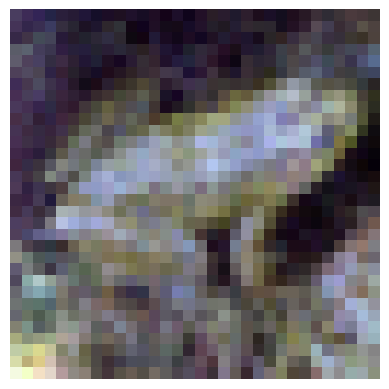

In [117]:
vis(pred) # no change in reconstruction :(

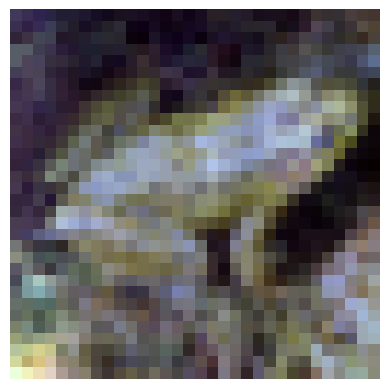

In [120]:
vis(img)

## Repeat but with token merging

In [192]:
# combine all elements into a single module
class ToMeBlock(torch.nn.Module):
    def __init__(self, dim, mlp_ratio=4, reduce_by=0.25, dropout_p=0.01):
        super().__init__()
        self.dropout_p = dropout_p
        self.norm1 = torch.nn.LayerNorm(dim)
        self.norm2 = torch.nn.LayerNorm(dim)
        self.to_q = torch.nn.Linear(dim, dim)
        self.to_k = torch.nn.Linear(dim, dim)
        self.to_v = torch.nn.Linear(dim, dim)
        self.mlp = Mlp(in_features=dim, hidden_features=dim*mlp_ratio, act_layer=torch.nn.GELU)
        self.reduce_by = reduce_by
    
    def forward(self, x):
        x = self.norm1(x)
        fcq, fck, fcv = self.to_q(x), self.to_k(x), self.to_v(x)
        # get merge and unmerge functions
        r = int(fcq.shape[1] * self.reduce_by)
        mq, uq = bipartite_soft_matching(fcq, r)
        # apply merge to q,k,v
        mfcq, mfck, mfcv = apply_merge(fcq, mq), apply_merge(fck, mq), apply_merge(fcv, mq)
        x = F.scaled_dot_product_attention(mfcq, mfck, mfcv, dropout_p=self.dropout_p)
        # unmerge output
        x = uq(x)
        x = self.norm2(x)
        x = self.mlp(x)
        return x
    
class Net(torch.nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=128, depth=1, reduce_by=0.25, mlp_ratio=4.0, block_fn=EncoderBlock):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        self.num_patches = self.patch_embed.num_patches
        self.pos_embed = torch.nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim), requires_grad=False)
       
        self.grid_size = int(self.num_patches**.5)
        # init weight for pos embed
        pos_embed_data = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], self.grid_size, cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed_data).float().unsqueeze(0))


        self.blocks = torch.nn.Sequential(*[
            block_fn(embed_dim, reduce_by=reduce_by)
            for i in range(depth)])

        self.norm = torch.nn.LayerNorm(embed_dim)
        self.fc = torch.nn.Linear(embed_dim, patch_size **2 * in_chans, bias=True)

    def forward(self, x):
        x = self.patch_embed(x)
        x += self.pos_embed[:, 1:, :]
        
        # encoder
        self.intermediates = []
        for blk in self.blocks:
            x = blk(x)
            self.intermediates.append(x)

        # decoder
        x = self.norm(x)
        x = self.fc(x)
        x = unpatchify(x, self.patch_embed.patch_size[0])
        return x
    
    def get_intermediates(self):
        return self.intermediates

In [193]:
loss_fn = torch.nn.L1Loss(reduction='sum')
# loss_fn = mse
net = Net(block_fn=ToMeBlock)
tome_optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

In [123]:
def train(model, img, num_iterations, loss_fn, optimizer):
    for i in range(num_iterations):
        optimizer.zero_grad()

        pred = model(img)
        
        loss = loss_fn(pred, img)
        
        if i % 100 == 0:
            print(loss.item())

        loss.backward()

        optimizer.step()

    return pred

In [129]:
s = time.time()
pred = train(net, batched_img, num_iterations, loss_fn, tome_optimizer)
e = time.time()
print("Train time:", e - s)

32.92155456542969
31.727272033691406
31.392972946166992
31.933677673339844
32.01995849609375
31.159841537475586
31.27376937866211
30.439483642578125
32.95621109008789
31.013126373291016
33.00354766845703
32.921382904052734
31.764175415039062
31.684598922729492
31.71811866760254
29.853939056396484
31.812679290771484
32.50682067871094
31.657785415649414
29.2689208984375
Train time: 9.551024913787842


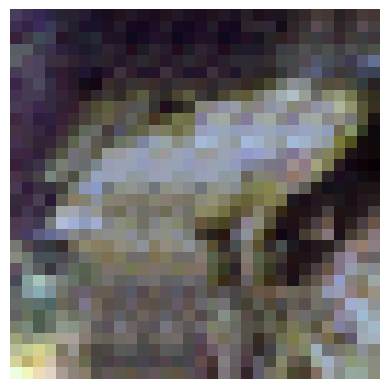

In [130]:
vis(pred)

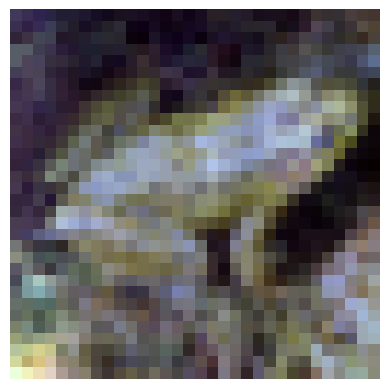

In [131]:
vis(img)

In [132]:
reduce_by = 0.5 # reduction ration for ToMe, merge up to 50% of tokens
net2 = Net(reduce_by=reduce_by, block_fn=ToMeBlock)
tome_optimizer2 = torch.optim.Adam(net2.parameters(), lr=lr, weight_decay=weight_decay)

In [135]:
s = time.time()
pred2 = train(net2, batched_img, num_iterations, loss_fn, tome_optimizer2)
e = time.time()
print("Train time:", e - s)

63.03984069824219
64.32379913330078
63.04087448120117
63.91613006591797
62.47169876098633
64.26122283935547
62.042415618896484
62.432373046875
64.24557495117188
61.080440521240234
62.417762756347656
61.7194709777832
62.91154098510742
62.164127349853516
60.667869567871094
60.80894470214844
61.11051559448242
60.97032928466797
61.828704833984375
59.60186767578125
Train time: 9.451464891433716


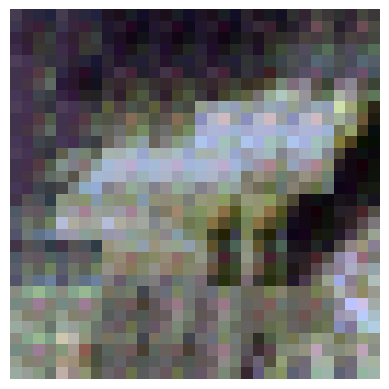

In [134]:
vis(pred2)

## Observations
There is no loss of information in the representation with token merging

Until getting closer to 50%

In [210]:
# larger image
# sample = prep_image('assets/tree_frog.jpg') # this sampling gives way too small values
sample = read_image('assets/tree_frog.jpg').to(dtype)
# # crop to 224 size
transform = transforms.Compose([transforms.RandomCrop(224),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
sample = transform(sample)
sample /= 255.0
sample = sample.unsqueeze(0)
sample

tensor([[[[ 0.1972,  0.1972,  0.1972,  ...,  0.0259,  0.0259,  0.0259],
          [ 0.1972,  0.1972,  0.1972,  ...,  0.0259,  0.0259,  0.0259],
          [ 0.1972,  0.1972,  0.1972,  ...,  0.0259,  0.0259,  0.0259],
          ...,
          [ 2.4577,  2.4748,  2.5262,  ...,  0.1629,  0.1629,  0.1629],
          [ 2.4577,  2.4063,  2.4405,  ...,  0.1629,  0.1629,  0.1629],
          [ 2.4919,  2.4063,  2.4063,  ...,  0.1629,  0.1629,  0.1629]],

         [[ 0.2196,  0.2196,  0.2196,  ...,  0.0270,  0.0270,  0.0270],
          [ 0.2196,  0.2196,  0.2196,  ...,  0.0270,  0.0270,  0.0270],
          [ 0.2196,  0.2196,  0.2196,  ...,  0.0270,  0.0270,  0.0270],
          ...,
          [ 2.2154,  2.1454,  2.1454,  ...,  0.1671,  0.1671,  0.1671],
          [ 2.2679,  2.1629,  2.1104,  ...,  0.1671,  0.1671,  0.1671],
          [ 2.3204,  2.1979,  2.0929,  ...,  0.1671,  0.1671,  0.1671]],

         [[ 0.0801,  0.0801,  0.0801,  ..., -0.0071, -0.0071, -0.0071],
          [ 0.0801,  0.0801,  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


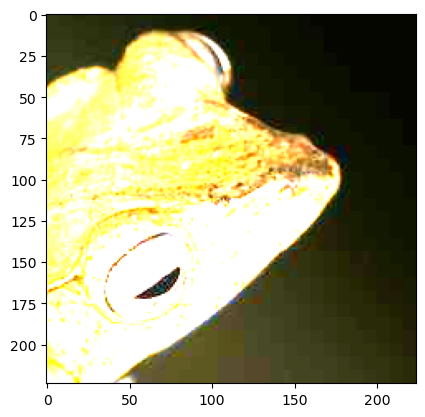

In [221]:
tmp_sample = sample.squeeze(0).permute(1, 2, 0).detach().numpy()
plt.imshow(tmp_sample)

In [231]:
# Control group but for larger image
net3 = Net(img_size=224, patch_size=16, embed_dim=64, depth=1, block_fn=EncoderBlock)
tome_optimizer3 = torch.optim.Adam(net3.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = torch.nn.L1Loss(reduce='sum')

In [232]:
s = time.time()
pred3 = train(net3, sample, num_iterations, loss_fn, tome_optimizer3)
e = time.time()
print("Train time:", e - s)

1.078188419342041
0.6214883923530579
0.6099309921264648
0.6279959678649902
0.6148061156272888
0.519111156463623
0.4281317889690399
0.41651651263237
0.3846549093723297
0.5638952851295471
0.3777531683444977
0.3763875961303711
0.3657463788986206
0.3679688572883606
0.35640591382980347
0.4482293128967285
0.3565771281719208
0.5158735513687134
0.36857402324676514
0.3565276265144348
Train time: 11.445381164550781


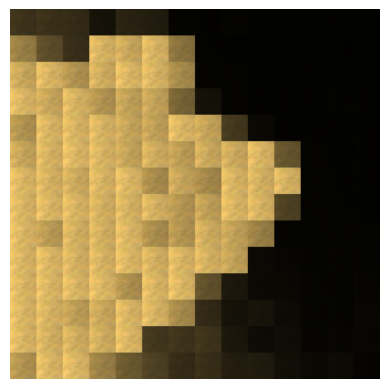

In [233]:
vis(pred3)